# 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 2. Extract Data

In [2]:
df = pd.read_csv('/content/taxi_fare.csv', parse_dates=['pickup_datetime'])

# menambah fitur waktu
waktu = df.pickup_datetime.dt

df['year']  = waktu.year
df['month'] = waktu.month
df['day']   = waktu.dayofweek
df['hour']   = waktu.hour

df.drop(columns=['pickup_datetime'],inplace=True)


# menambah fitur jarak
xp = df['pickup_latitude']
xd = df['dropoff_latitude']

yp = df['pickup_longitude']
yd = df['dropoff_longitude']

df['jarak'] = np.abs(xp-xd)+np.abs(yp-yd)
df.drop(columns=['pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude'], inplace=True)


df.head()

,fare_amount,passenger_count,year,month,day,hour,jarak
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# 3. Data Preprocessing

## 3.1. Data Splitting

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['fare_amount'])
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

## 3.2. Feature Engineering
1. imputing missing value
2. scaling data
3. polynomial features
4. onehot encoding, etc.

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pre = Pipeline([("num_imputer",SimpleImputer(strategy="mean")),
                    ("transform",MinMaxScaler()),
                    ("poly",PolynomialFeatures(degree=2,interaction_only=True,include_bias=False))])
cat_pre = Pipeline([("cat_imputer",SimpleImputer(strategy="most_frequent")),
                    ("onehot",OneHotEncoder(handle_unknown='ignore'))])

num_kolom = X_train.select_dtypes(include=np.number).columns
cat_kolom = X_train.select_dtypes(exclude=np.number).columns

preprocessing = ColumnTransformer([("num_pipe", num_pre, num_kolom),
                                   ("cat_pipe", cat_pre, cat_kolom)])

In [5]:
preprocessing.fit(X_train)

X_train_clean = preprocessing.transform(X_train)
X_test_clean  = preprocessing.transform(X_test)

### Sanity Check

In [6]:
pd.DataFrame(X_train_clean, columns=preprocessing.get_feature_names_out()).head()

,num_pipe__passenger_count,num_pipe__year,num_pipe__month,num_pipe__day,num_pipe__hour,num_pipe__jarak,num_pipe__passenger_count year,num_pipe__passenger_count month,num_pipe__passenger_count day,num_pipe__passenger_count hour,...,num_pipe__year month,num_pipe__year day,num_pipe__year hour,num_pipe__year jarak,num_pipe__month day,num_pipe__month hour,num_pipe__month jarak,num_pipe__day hour,num_pipe__day jarak,num_pipe__hour jarak
0,0.166667,0.000000,0.727273,0.833333,0.434783,0.000044,0.000000,0.121212,0.138889,0.072464,...,0.000000,0.000000,0.000000,0.000000,0.606061,0.316206,0.000032,0.362319,0.000037,0.000019
1,0.500000,0.166667,0.181818,0.500000,0.434783,0.000026,0.083333,0.090909,0.250000,0.217391,...,0.030303,0.083333,0.072464,0.000004,0.090909,0.079051,0.000005,0.217391,0.000013,0.000011
2,0.333333,0.166667,0.272727,0.166667,0.739130,0.000033,0.055556,0.090909,0.055556,0.246377,...,0.045455,0.027778,0.123188,0.000006,0.045455,0.201581,0.000009,0.123188,0.000006,0.000024
3,0.166667,0.666667,0.181818,0.833333,1.000000,0.000676,0.111111,0.030303,0.138889,0.166667,...,0.121212,0.555556,0.666667,0.000451,0.151515,0.181818,0.000123,0.833333,0.000564,0.000676
4,0.166667,0.500000,0.545455,1.000000,0.782609,0.000074,0.083333,0.090909,0.166667,0.130435,...,0.272727,0.500000,0.391304,0.000037,0.545455,0.426877,0.000040,0.782609,0.000074,0.000058


# 4. Build ANN Model for Regression

In [7]:
import tensorflow as tf

## 4.1. Model Architecture

In [8]:
model = tf.keras.Sequential([
    ## Input Layer, sekaligus terhubung ke hidden layer 1
    ## Pastikan input_dim adalah dimensi data/banyak kolom yang akan diproses
    tf.keras.layers.Dense(input_dim=X_train_clean.shape[1],units=4,activation='relu'),

    ## Hidden Layer 2
    tf.keras.layers.Dense(units=4,activation='relu'),

    ## Output Layer
    ## Pastikan unitsnya disesuaikan dengan dimensi data yang mau dipredict
    ## Range activation functionnya juga disesuaikan
    tf.keras.layers.Dense(units=1,activation='relu')
    ])


## Note untuk output layer :
## 1. Binary Classification : units=1, activation='sigmoid'
## 2. Regression : units=1, activation='linear' atau activation='relu'
## 3. MultiClass : units=sesuaikan dengan jumlah class, activation='softmax'

Output Layer : karena kita mau predik harga argo taxi, maka harus skalar, bernilai kontinu, positif

## 4.2. Optimizer

In [9]:
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
              metrics=['r2'])

## 4.3. Summary

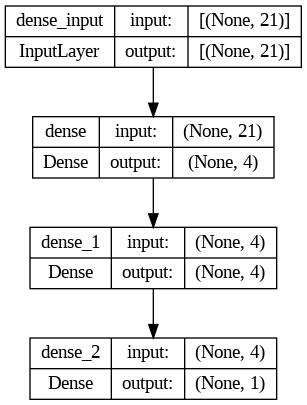

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 88        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 113 (452.00 Byte)
Trainable params: 113 (452.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
